# Baseline Experiment 2: Training Random Forest Classifier

Using Grid Search with 5-fold Cross-Validation, with a 70/30 train/test split.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib
import sklearn
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, plot_confusion_matrix
from sklearn.utils import class_weight  # For balanced class weighted classification training

# For reproducible results
RANDOM_STATE_SEED = 420

In [2]:
df_dataset = pd.read_csv("processed_friday_dataset.csv")

In [3]:
df_dataset

,Flow Duration,Tot Fwd Pkts,Tot Bwd Pkts,TotLen Fwd Pkts,TotLen Bwd Pkts,Fwd Pkt Len Max,Fwd Pkt Len Min,Fwd Pkt Len Mean,Fwd Pkt Len Std,Bwd Pkt Len Max,...,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Protocol_17,Protocol_6,Label
0,141385,9,7,553,3773.0,202,0,61.444444,87.534438,1460,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0,1,0
1,281,2,1,38,0.0,38,0,19.000000,26.870058,0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0,1,0
2,279824,11,15,1086,10527.0,385,0,98.727273,129.392497,1460,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0,1,0
3,132,2,0,0,0.0,0,0,0.000000,0.000000,0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0,1,0
4,274016,9,13,1285,6141.0,517,0,142.777778,183.887722,1460,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1364426,25,1,1,0,0.0,0,0,0.000000,0.000000,0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0,1,1
1364427,37,1,1,0,0.0,0,0,0.000000,0.000000,0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0,1,1
1364428,112640543,3,0,0,0.0,0,0,0.000000,0.000000,0,...,0.0,0.0,0.0,56300000.0,7.778175,56300000.0,56300000.0,0,0,0
1364429,41,1,1,0,0.0,0,0,0.000000,0.000000,0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0,1,1


In [4]:
df_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1364431 entries, 0 to 1364430
Data columns (total 73 columns):
 #   Column             Non-Null Count    Dtype  
---  ------             --------------    -----  
 0   Flow Duration      1364431 non-null  int64  
 1   Tot Fwd Pkts       1364431 non-null  int64  
 2   Tot Bwd Pkts       1364431 non-null  int64  
 3   TotLen Fwd Pkts    1364431 non-null  int64  
 4   TotLen Bwd Pkts    1364431 non-null  float64
 5   Fwd Pkt Len Max    1364431 non-null  int64  
 6   Fwd Pkt Len Min    1364431 non-null  int64  
 7   Fwd Pkt Len Mean   1364431 non-null  float64
 8   Fwd Pkt Len Std    1364431 non-null  float64
 9   Bwd Pkt Len Max    1364431 non-null  int64  
 10  Bwd Pkt Len Min    1364431 non-null  int64  
 11  Bwd Pkt Len Mean   1364431 non-null  float64
 12  Bwd Pkt Len Std    1364431 non-null  float64
 13  Flow IAT Mean      1364431 non-null  float64
 14  Flow IAT Std       1364431 non-null  float64
 15  Flow IAT Max       1364431 non-n

### 1- Making an 70/30 train/test split

In [5]:
train, test = train_test_split(df_dataset, test_size=0.3, random_state=RANDOM_STATE_SEED)

In [6]:
train

,Flow Duration,Tot Fwd Pkts,Tot Bwd Pkts,TotLen Fwd Pkts,TotLen Bwd Pkts,Fwd Pkt Len Max,Fwd Pkt Len Min,Fwd Pkt Len Mean,Fwd Pkt Len Std,Bwd Pkt Len Max,...,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Protocol_17,Protocol_6,Label
358501,1932,1,1,34,211.0,34,34,34.000000,0.000000,211,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0
205523,10230,3,4,326,129.0,326,0,108.666667,188.216188,112,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,1
334013,29643,1,1,32,121.0,32,32,32.000000,0.000000,121,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0
1244653,94265,3,0,0,0.0,0,0,0.000000,0.000000,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,1
1309914,60062,3,0,0,0.0,0,0,0.000000,0.000000,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1049785,4611411,4,5,935,374.0,935,0,233.750000,467.500000,374,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,0
178094,11867,3,4,326,129.0,326,0,108.666667,188.216188,112,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,1
510579,541109,6,5,455,338.0,140,0,75.833333,62.936211,145,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,0
1242184,3404233,5,3,935,322.0,935,0,187.000000,418.144712,322,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,0


In [7]:
test

,Flow Duration,Tot Fwd Pkts,Tot Bwd Pkts,TotLen Fwd Pkts,TotLen Bwd Pkts,Fwd Pkt Len Max,Fwd Pkt Len Min,Fwd Pkt Len Mean,Fwd Pkt Len Std,Bwd Pkt Len Max,...,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Protocol_17,Protocol_6,Label
421031,5856314,4,4,97,231.0,97,0,24.25,48.500000,231,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,0
1026751,4442833,5,3,935,348.0,935,0,187.00,418.144712,348,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,0
882513,67116,3,0,0,0.0,0,0,0.00,0.000000,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,1
413896,2681,1,1,34,155.0,34,34,34.00,0.000000,155,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0
189064,1391793,8,7,1132,1581.0,661,0,141.50,222.792023,1173,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
341771,4975198,2,0,0,0.0,0,0,0.00,0.000000,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,0
1281286,4383470,5,4,935,668.0,935,0,187.00,418.144712,334,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,0
606144,15125,2,1,0,0.0,0,0,0.00,0.000000,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,0
188978,1685281,8,7,1144,1581.0,677,0,143.00,227.969923,1173,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,0


#### MinMax Scaling of numerical attributes

In [8]:
numerical_cols = train.columns[:-3]
numerical_cols

Index(['Flow Duration', 'Tot Fwd Pkts', 'Tot Bwd Pkts', 'TotLen Fwd Pkts',
       'TotLen Bwd Pkts', 'Fwd Pkt Len Max', 'Fwd Pkt Len Min',
       'Fwd Pkt Len Mean', 'Fwd Pkt Len Std', 'Bwd Pkt Len Max',
       'Bwd Pkt Len Min', 'Bwd Pkt Len Mean', 'Bwd Pkt Len Std',
       'Flow IAT Mean', 'Flow IAT Std', 'Flow IAT Max', 'Flow IAT Min',
       'Fwd IAT Tot', 'Fwd IAT Mean', 'Fwd IAT Std', 'Fwd IAT Max',
       'Fwd IAT Min', 'Bwd IAT Tot', 'Bwd IAT Mean', 'Bwd IAT Std',
       'Bwd IAT Max', 'Bwd IAT Min', 'Fwd Header Len', 'Bwd Header Len',
       'Fwd Pkts/s', 'Bwd Pkts/s', 'Pkt Len Min', 'Pkt Len Max',
       'Pkt Len Mean', 'Pkt Len Std', 'Pkt Len Var', 'FIN Flag Cnt',
       'SYN Flag Cnt', 'RST Flag Cnt', 'PSH Flag Cnt', 'ACK Flag Cnt',
       'URG Flag Cnt', 'CWE Flag Count', 'ECE Flag Cnt', 'Down/Up Ratio',
       'Pkt Size Avg', 'Fwd Seg Size Avg', 'Bwd Seg Size Avg',
       'Fwd Byts/b Avg', 'Fwd Pkts/b Avg', 'Fwd Blk Rate Avg',
       'Bwd Byts/b Avg', 'Bwd Pkts/b Avg', 'B

In [9]:
min_max_scaler = MinMaxScaler().fit(train[numerical_cols])

In [10]:
train[numerical_cols] = min_max_scaler.transform(train[numerical_cols])

In [11]:
train

,Flow Duration,Tot Fwd Pkts,Tot Bwd Pkts,TotLen Fwd Pkts,TotLen Bwd Pkts,Fwd Pkt Len Max,Fwd Pkt Len Min,Fwd Pkt Len Mean,Fwd Pkt Len Std,Bwd Pkt Len Max,...,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Protocol_17,Protocol_6,Label
358501,0.000016,0.000000,0.000014,0.000031,0.000002,0.011676,0.023288,0.023288,0.000000,0.024286,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0
205523,0.000085,0.000046,0.000058,0.000296,0.000001,0.111951,0.000000,0.074429,0.182314,0.012891,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,1
334013,0.000247,0.000000,0.000014,0.000029,0.000001,0.010989,0.021918,0.021918,0.000000,0.013927,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0
1244653,0.000786,0.000046,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,1
1309914,0.000501,0.000046,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1049785,0.038428,0.000070,0.000072,0.000850,0.000004,0.321085,0.000000,0.160103,0.452839,0.043048,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,0
178094,0.000099,0.000046,0.000058,0.000296,0.000001,0.111951,0.000000,0.074429,0.182314,0.012891,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,1
510579,0.004509,0.000116,0.000072,0.000413,0.000003,0.048077,0.000000,0.051941,0.060962,0.016690,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,0
1242184,0.028369,0.000093,0.000043,0.000850,0.000003,0.321085,0.000000,0.128082,0.405031,0.037063,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,0


In [12]:
test[numerical_cols] = min_max_scaler.transform(test[numerical_cols])

In [13]:
test

,Flow Duration,Tot Fwd Pkts,Tot Bwd Pkts,TotLen Fwd Pkts,TotLen Bwd Pkts,Fwd Pkt Len Max,Fwd Pkt Len Min,Fwd Pkt Len Mean,Fwd Pkt Len Std,Bwd Pkt Len Max,...,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Protocol_17,Protocol_6,Label
421031,0.048803,0.000070,0.000058,0.000088,0.000002,0.033310,0.000000,0.016610,0.046979,0.026588,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,0
1026751,0.037024,0.000093,0.000043,0.000850,0.000003,0.321085,0.000000,0.128082,0.405031,0.040055,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,0
882513,0.000559,0.000046,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,1
413896,0.000022,0.000000,0.000014,0.000031,0.000002,0.011676,0.023288,0.023288,0.000000,0.017841,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0
189064,0.011598,0.000162,0.000101,0.001029,0.000016,0.226992,0.000000,0.096918,0.215805,0.135014,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
341771,0.041460,0.000023,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,0
1281286,0.036529,0.000093,0.000058,0.000850,0.000007,0.321085,0.000000,0.128082,0.405031,0.038444,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,0
606144,0.000126,0.000023,0.000014,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,0
188978,0.014044,0.000162,0.000101,0.001039,0.000016,0.232486,0.000000,0.097945,0.220821,0.135014,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,0


### 2- Checking label distribution

In [14]:
print("Full dataset:\n")
print("Benign: " + str(df_dataset["Label"].value_counts()[[0]].sum()))
print("Malicious: " + str(df_dataset["Label"].value_counts()[[1]].sum()))
print("---------------")

print("Training set:\n")
print("Benign: " + str(train["Label"].value_counts()[[0]].sum()))
print("Malicious: " + str(train["Label"].value_counts()[[1]].sum()))
print("---------------")

print("Test set:\n")
print("Benign: " + str(test["Label"].value_counts()[[0]].sum()))
print("Malicious: " + str(test["Label"].value_counts()[[1]].sum()))

Full dataset:

Benign: 1074342
Malicious: 290089
---------------
Training set:

Benign: 751849
Malicious: 203252
---------------
Test set:

Benign: 322493
Malicious: 86837


### 3- Splitting to X_train, y_train, X_test, y_test

In [15]:
y_train = np.array(train.pop("Label")) # pop removes "Label" from the dataframe
X_train = train.values

print(type(X_train))
print(type(y_train))
print(X_train.shape)
print(y_train.shape)

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
(955101, 72)
(955101,)


In [16]:
y_test = np.array(test.pop("Label")) # pop removes "Label" from the dataframe
X_test = test.values

print(type(X_test))
print(type(y_test))
print(X_test.shape)
print(y_test.shape)

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
(409330, 72)
(409330,)


### 4- Fitting Random Forest model

In [17]:
# Calculating class weights for balanced class weighted classifier training
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)

print(class_weights)

# Must be in dict format for scikitlearn
class_weights = {
    0: class_weights[0],
    1: class_weights[1]
}

print(class_weights)

[0.6351681  2.34954884]
{0: 0.6351680989134786, 1: 2.3495488359278136}


In [18]:
model = RandomForestClassifier(
    n_estimators=100,
    criterion='gini',
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    min_weight_fraction_leaf=0.0,
    max_features='auto',
    max_leaf_nodes=None,
    min_impurity_decrease=0.0,
    bootstrap=True,
    oob_score=False,
    n_jobs=None,
    random_state=None,
    verbose=0,
    warm_start=False,
    class_weight=class_weights,
    ccp_alpha=0.0,
    max_samples=None
)

hyperparameters = {
    'n_estimators': [50, 75, 100, 125, 150]
}

In [19]:
clf = GridSearchCV(
    estimator=model,
    param_grid=hyperparameters,
    cv=5,
    verbose=1,
    n_jobs=-1  # Use all available CPU cores
)

In [20]:
clf.fit(X=X_train, y=y_train)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


GridSearchCV(cv=5,
             estimator=RandomForestClassifier(class_weight={0: 0.6351680989134786,
                                                            1: 2.3495488359278136}),
             n_jobs=-1, param_grid={'n_estimators': [50, 75, 100, 125, 150]},
             verbose=1)

### 5- Extracting best performing model in the 5-fold cross-validation Grid Search

In [21]:
print("Accuracy score on Validation set: \n")
print(clf.best_score_ )
print("---------------")
print("Best performing hyperparameters on Validation set: ")
print(clf.best_params_)
print("---------------")
print(clf.best_estimator_)

Accuracy score on Validation set: 

0.9996345936035459
---------------
Best performing hyperparameters on Validation set: 
{'n_estimators': 125}
---------------
RandomForestClassifier(class_weight={0: 0.6351680989134786,
                                     1: 2.3495488359278136},
                       n_estimators=125)


In [22]:
model = clf.best_estimator_

In [23]:
model

RandomForestClassifier(class_weight={0: 0.6351680989134786,
                                     1: 2.3495488359278136},
                       n_estimators=125)

### 6- Evaluating on Test set

In [24]:
predictions = model.predict(X_test)

In [25]:
predictions

array([0, 0, 1, ..., 0, 0, 0])

#### 6.1 Accuracy on Test set

In [26]:
print(accuracy_score(y_test, predictions))

0.9990374514450443


#### 6.2 Confusion matrix

In [27]:
cm = confusion_matrix(y_test, predictions)
print(cm)

[[322130    363]
 [    31  86806]]


/home/tamer/anaconda3/envs/cic-ids-2018/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


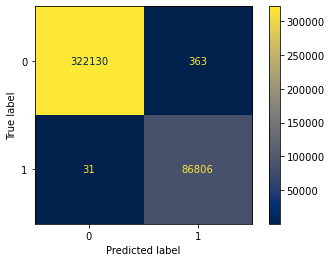

In [28]:
plot_confusion_matrix(model, X_test, y_test, cmap="cividis")

#### 6.3 Classification report

In [29]:
print(classification_report(y_test, predictions, digits=5))

              precision    recall  f1-score   support

           0    0.99990   0.99887   0.99939    322493
           1    0.99584   0.99964   0.99774     86837

    accuracy                        0.99904    409330
   macro avg    0.99787   0.99926   0.99856    409330
weighted avg    0.99904   0.99904   0.99904    409330



### 7- Saving model

In [30]:
joblib.dump(model, "trained_models/random-forest-classifier.pkl")

['trained_models/random-forest-classifier.pkl']

### 8- Testing loading model

In [31]:
model = joblib.load("trained_models/random-forest-classifier.pkl")

In [32]:
model

RandomForestClassifier(class_weight={0: 0.6351680989134786,
                                     1: 2.3495488359278136},
                       n_estimators=125)